In [614]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.cluster import KMeans

In [6]:
img_path = []
img_name = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        img_path.append(os.path.join(dirname, filename))
        img_name.append(os.path.basename(dirname))

df = pd.DataFrame({"img_path":img_path,"img_name":img_name})
df.head()

,img_path,img_name
0,/kaggle/input/sea-animals-image-dataste/Pengui...,Penguin
1,/kaggle/input/sea-animals-image-dataste/Pengui...,Penguin
2,/kaggle/input/sea-animals-image-dataste/Pengui...,Penguin
3,/kaggle/input/sea-animals-image-dataste/Pengui...,Penguin
4,/kaggle/input/sea-animals-image-dataste/Pengui...,Penguin


On va tenter de segmenter des images avec différentes méthode. On commence par appliquer des morphologies mathématiques.

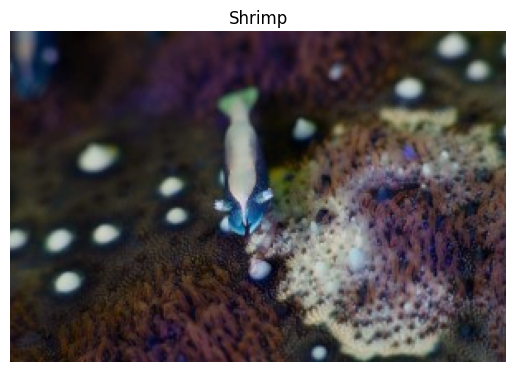

In [402]:
np.random.seed(2)

r = np.random.randint(0,len(df))
img = cv2.imread(df["img_path"][r])

plt.imshow(img)
plt.title(df["img_name"][r])
plt.axis("off")
plt.show()

Tout d'abord, il faut transformer l'image en niveaux de gris, et la binariser.

In [55]:
def binar(img,tau):
    
    #on normalise l'image
  #  img = (img-np.min(img))/(np.max(img)-np.min(img))

    #on crée une image de même taille que img
    img_bin = np.zeros_like(img)

    #on met les pixels en blanc s'ils sont supérieurs à tau
    img_bin[img>tau] = 1

    return img_bin

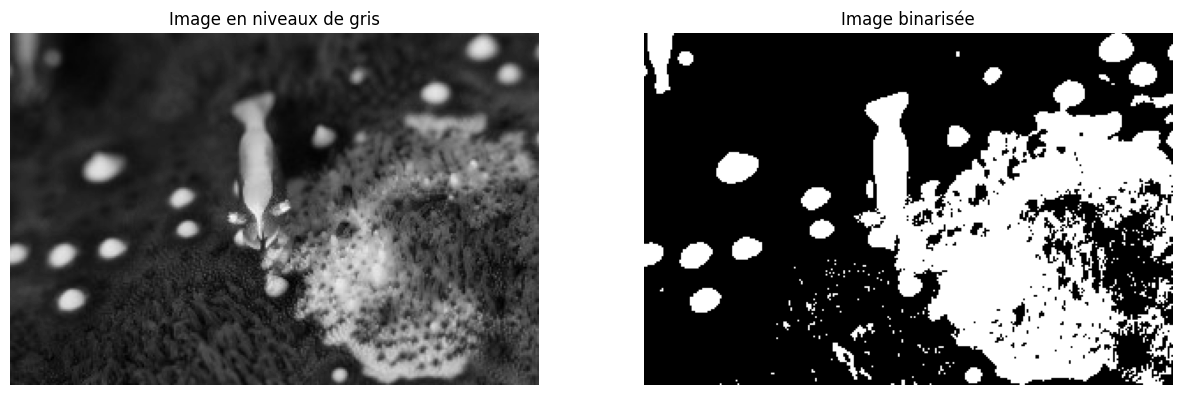

In [403]:
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
tau = np.mean(img_gray)
img_bin = binar(img_gray,tau)

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,10))

ax[0].imshow(img_gray,cmap="gray")
ax[0].set_title("Image en niveaux de gris")
ax[0].axis("off")

ax[1].imshow(img_bin, cmap="gray")
ax[1].set_title("Image binarisée")
ax[1].axis("off")

plt.show()

On peut faire une dilatation ou une érosion sur l'image. On choisit un noyau circulaire.

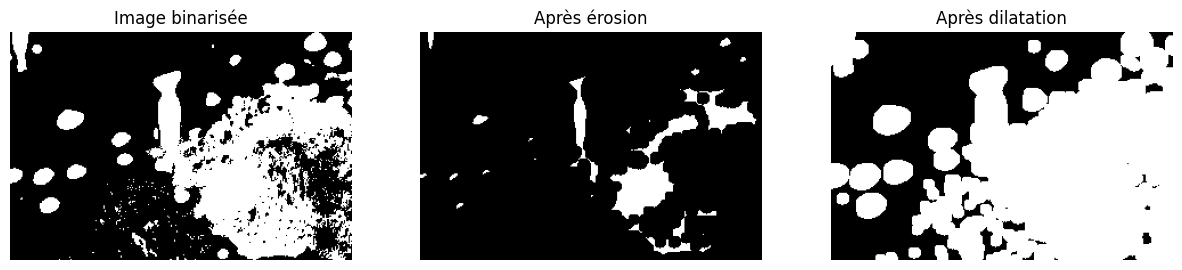

In [404]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))

img_ero = cv2.erode(img_bin,kernel)
img_dil = cv2.dilate(img_bin,kernel)

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,10))

ax[0].imshow(img_bin,cmap="gray")
ax[0].set_title("Image binarisée")
ax[0].axis("off")

ax[1].imshow(img_ero, cmap="gray")
ax[1].set_title("Après érosion")
ax[1].axis("off")

ax[2].imshow(img_dil, cmap="gray")
ax[2].set_title("Après dilatation")
ax[2].axis("off")

plt.show()

L'érosion étend les pixels noirs alors que la dilatation étend les pixels blancs. On effectue maintenant ces opérations à la suite (ouverture ou fermeture).

In [40]:
def ouverture(img,kernel):
  img_ero = cv2.erode(img,kernel)
  img_dil = cv2.dilate(img_ero,kernel)

  return img_dil

def fermeture(img,kernel):
  img_dil = cv2.dilate(img,kernel)
  img_ero = cv2.erode(img_dil,kernel)

  return img_ero

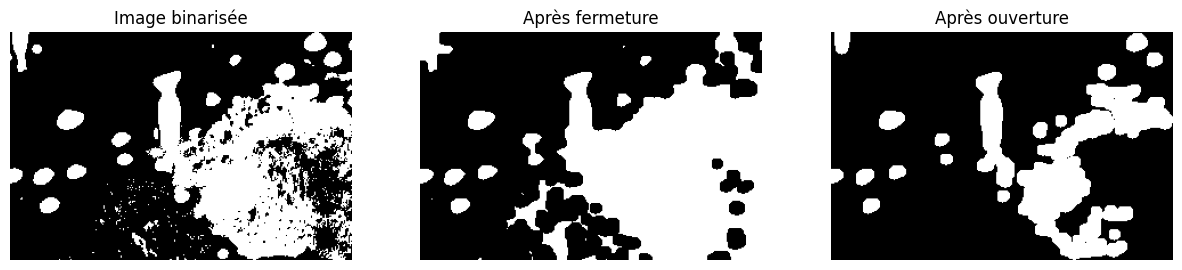

In [405]:
img_ferm = fermeture(img_bin,kernel)
img_ouv = ouverture(img_bin,kernel)

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,10))

ax[0].imshow(img_bin,cmap="gray")
ax[0].set_title("Image binarisée")
ax[0].axis("off")

ax[1].imshow(img_ferm, cmap="gray")
ax[1].set_title("Après fermeture")
ax[1].axis("off")

ax[2].imshow(img_ouv, cmap="gray")
ax[2].set_title("Après ouverture")
ax[2].axis("off")

plt.show()

In [219]:
def segment(img,tau,kernel,fonction=fermeture,pixel=1):

    #on transforme l'image en niveaux de gris
    if len(img.shape)==3:
      img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
      img_gray = img

    #on applique la fonction qui binarise l'image
    img_bin = binar(img_gray,tau)

    #on effectue une fermeture ou une ouverture
    img_ferm = fonction(img_bin,kernel)

    #on crée une matrice nulle de même taille que l'image originale
    if pixel == 1:
      img_seg = np.zeros_like(img)
    else:
      img_seg = np.ones_like(img)*255


    #pour chacun des canal, on ne garde que les pixels qui valent 1 dans l'image fermée
    for i in range(3):
        img_seg[:,:,i][img_ferm == pixel] = img[:,:,i][img_ferm == pixel]

    return img_seg

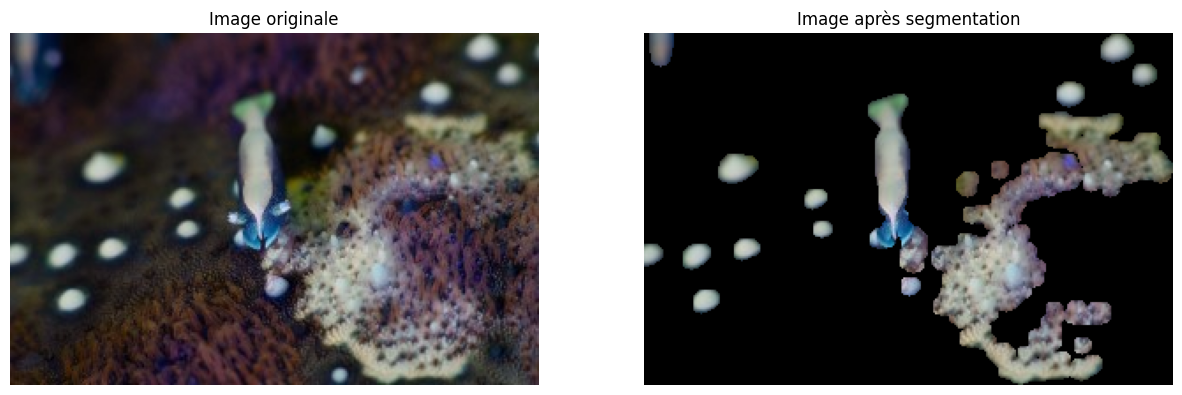

In [407]:
img_seg = segment(img,tau,kernel,fonction=ouverture,pixel=1)

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,10))

ax[0].imshow(img)
ax[0].set_title("Image originale")
ax[0].axis("off")

ax[1].imshow(img_seg)
ax[1].set_title("Image après segmentation")
ax[1].axis("off")

plt.show()

Il reste des éléments gênants, on peut couper l'image pour les retirer.

In [408]:
img_seg.shape

(200, 300, 3)

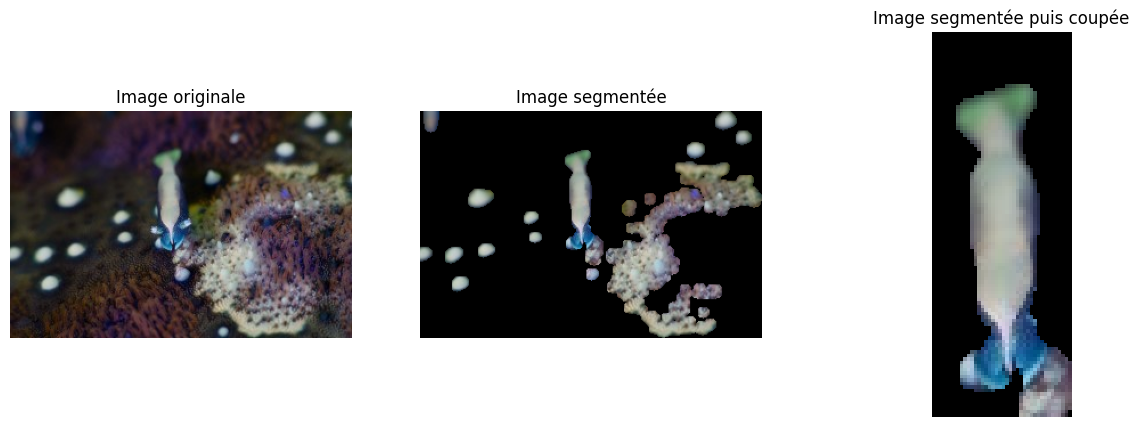

In [423]:
img_cropped = img_seg[20:130, 120:160]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax[0].imshow(img)
ax[0].set_title("Image originale")
ax[0].axis("off")

ax[1].imshow(img_seg)
ax[1].set_title("Image segmentée")
ax[1].axis("off")

ax[2].imshow(img_cropped)
ax[2].set_title("Image segmentée puis coupée")
ax[2].axis("off")


plt.show()

On a retiré une grande partie du fond, ce qui pourra rendre le traitement plus aisé.

Une autre méthode est de détecter des clusters.

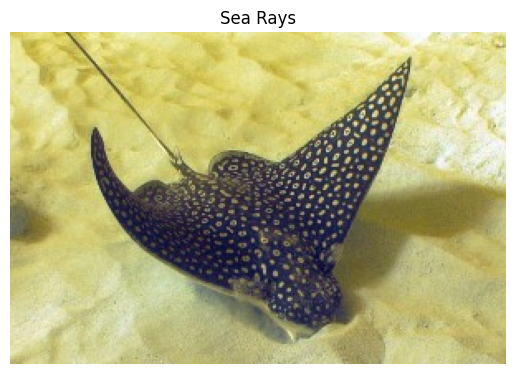

In [599]:
np.random.seed(2632)

r = np.random.randint(0,len(df))
img = cv2.imread(df["img_path"][r])

plt.imshow(img)
plt.title(df["img_name"][r])
plt.axis("off")
plt.show()

In [600]:
n_clusters = 10

img_reshaped = (img/255).reshape((-1, 3))
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10).fit(img_reshaped)
pic2show = kmeans.cluster_centers_[kmeans.labels_]
cluster_pic = np.reshape(pic2show,img.shape)

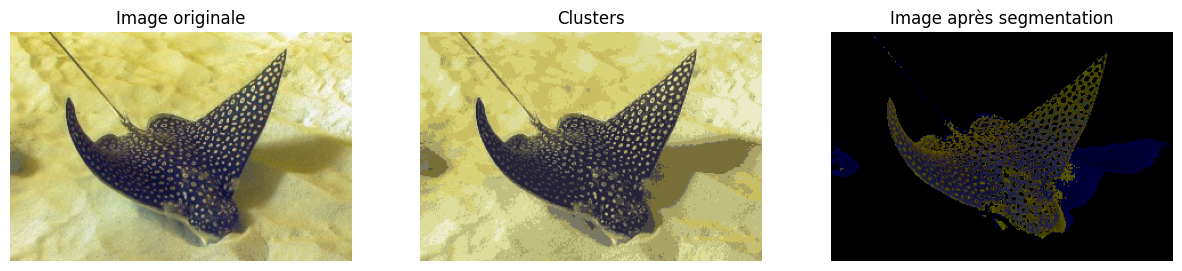

In [601]:
img_seg = np.zeros_like(img)
clusters = range(0,2)

for i in range(3):
    pixels = np.unique(np.reshape(kmeans.cluster_centers_[kmeans.labels_][:,i],img.shape[:2]))
    for cluster in clusters:
        img_seg[:,:,i][cluster_pic[:,:,i] == pixels[cluster]] = img[:,:,i][cluster_pic[:,:,i] == pixels[cluster]]

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,10))

ax[0].imshow(img)
ax[0].set_title("Image originale")
ax[0].axis("off")

ax[1].imshow(cluster_pic)
ax[1].set_title("Clusters")
ax[1].axis("off")

ax[2].imshow(img_seg)
ax[2].set_title("Image après segmentation")
ax[2].axis("off")

plt.show()

Il y a des trous dans la raie, on peut appliquer une dilatation pour les boucher.

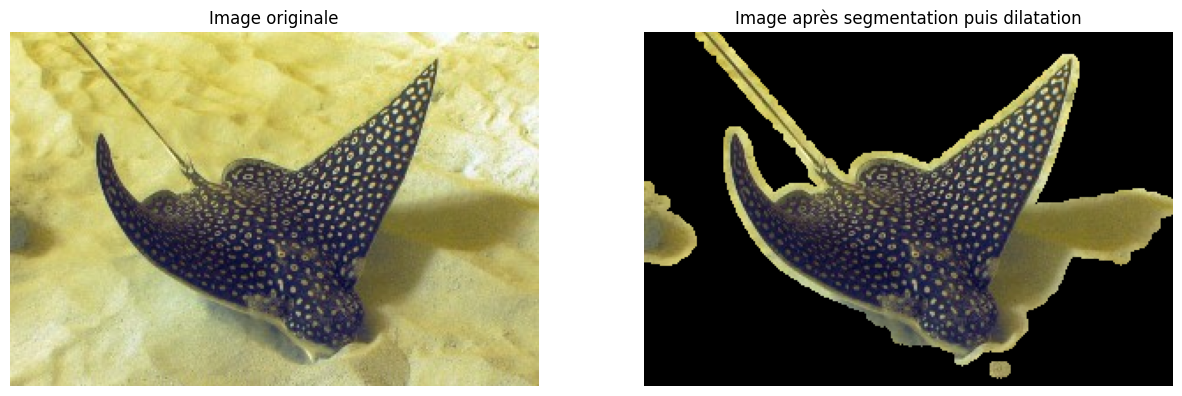

In [613]:
img_gray = cv2.cvtColor(img_seg,cv2.COLOR_BGR2GRAY)

tau = np.mean(img_gray)
img_bin = binar(img_gray,10)

img_seg2 = np.zeros_like(img)
img_dil = cv2.dilate(img_bin,kernel)

for i in range(3):
    img_seg2[:,:,i][img_dil == pixel] = img[:,:,i][img_dil == pixel]


fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,10))

ax[0].imshow(img)
ax[0].set_title("Image originale")
ax[0].axis("off")

ax[1].imshow(img_seg2)
ax[1].set_title("Image après segmentation puis dilatation")
ax[1].axis("off")

plt.show()

La segmentation n'est pas idéale, mais il y aura tout de même moins d'informations à traiter.

On peut aussi segmenter une image selon une certaine couleur. Par exemple, sur cette image où l'on aperçoit deux étoiles de mer, dont l'une des deux est d'un bleu très net.

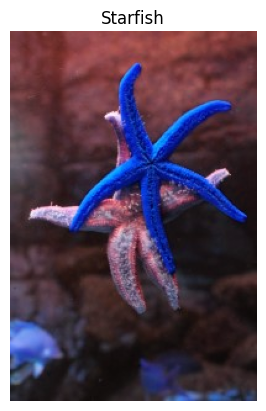

In [361]:
np.random.seed(383)

r = np.random.randint(0,len(df))
img = cv2.imread(df["img_path"][r])

plt.imshow(img)
plt.title(df["img_name"][r])
plt.axis("off")
plt.show()

On va créer un masque bleu, et l'appliquer à l'image.

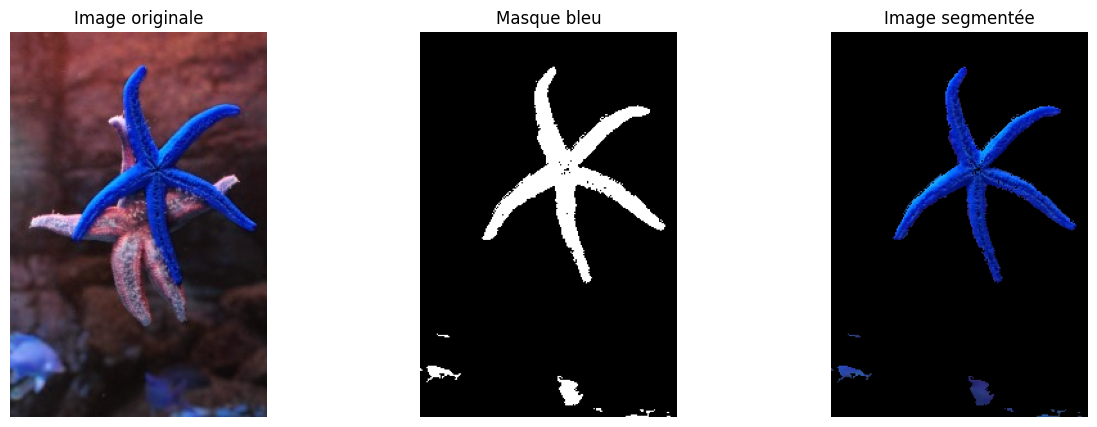

In [362]:

#définition de la gamme dans laquelle on veut garder la couleur
lower_blue = np.array([0, 0, 100])
upper_blue = np.array([50, 255, 255])

#création du masque
blue_mask = cv2.inRange(img_rgb, lower_blue, upper_blue)
img_seg = cv2.bitwise_and(img, img, mask=blue_mask)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax[0].imshow(img_rgb)
ax[0].set_title("Image originale")
ax[0].axis("off")

ax[1].imshow(blue_mask, cmap='gray')
ax[1].set_title("Masque bleu")
ax[1].axis("off")

ax[2].imshow(img_seg)
ax[2].set_title("Image segmentée")
ax[2].axis("off")

plt.show()


On a bien isolé l'étoile de mer, mais il y a quelque coquillages qui restent, on peut maintenant simplement les couper.

In [375]:
img_seg.shape

(300, 200, 3)

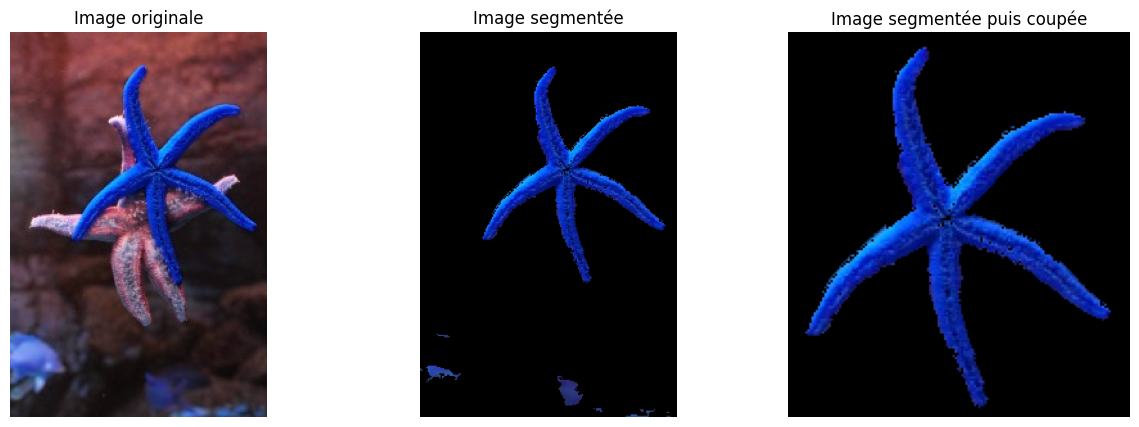

In [382]:
img_cropped = img_seg[20:200, 40:200]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax[0].imshow(img_rgb)
ax[0].set_title("Image originale")
ax[0].axis("off")

ax[1].imshow(img_seg)
ax[1].set_title("Image segmentée")
ax[1].axis("off")

ax[2].imshow(img_cropped)
ax[2].set_title("Image segmentée puis coupée")
ax[2].axis("off")


plt.show()

Ces techniques ne fonctionnent pas pour tous les cas, l'idéal serait d'entraîner un modèle avec par exemple Mask-R CNN : https://blog.roboflow.com/mask-rcnn/